In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5


In [3]:
f(3)

20

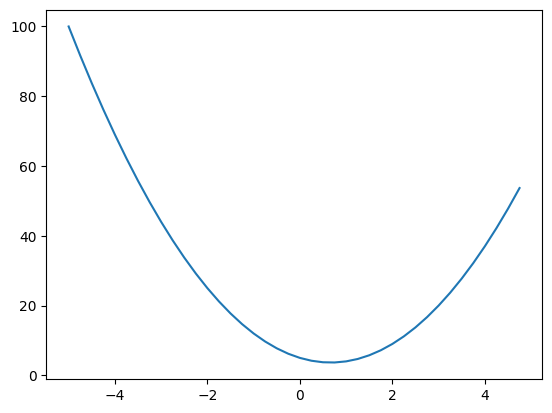

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h= 0.00001
x = 2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [6]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c

c+= h
d2= a*b+c

print('d1',d1)
print('d2',d2)

print('slope',((d2-d1)/h))

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [7]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(L)

In [ ]:
# 2. Calculate the Gradient of the Loss L with Respect to Each Variable:

# Start with the gradient of L with respect to L, which is 1  : 

# (since dL/dL = 1).

# Gradient of L with respect to d:
# dL/dd = d(d * f)/dd = f = -2.0

# Gradient of L with respect to f:
# dL/df = d(d * f)/df = d = 4.0

# Gradient of L with respect to e:
# Since d = e + c,
# dL/de = dL/dd * dd/de = -2.0 * 1 = -2.0

# Gradient of L with respect to c:
# Since d = e + c,
# dL/dc = dL/dd * dd/dc = -2.0 * 1 = -2.0

# Gradient of L with respect to a:
# Since e = a * b,
# dL/da = dL/de * de/da = -2.0 * b = -2.0 * -3.0 = 6.0

# Gradient of L with respect to b:
# Since e = a * b,
# dL/db = dL/de * de/db = -2.0 * a = -2.0 * 2.0 = -4.0

# 3. Summary of Gradients:
# dL/da = 6.0
# dL/db = -4.0
# dL/dc = -2.0
# dL/de = -2.0
# dL/df = 4.0

# For a: The gradient is positive (6.0), so to reduce L, we should decrease a.
# For b: The gradient is negative (-4.0), so to reduce L, we should increase b.
# For c: The gradient is negative (-2.0), so to reduce L, we should increase c.
# For f: The gradient is positive (4.0), so to reduce L, we should decrease f.


In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

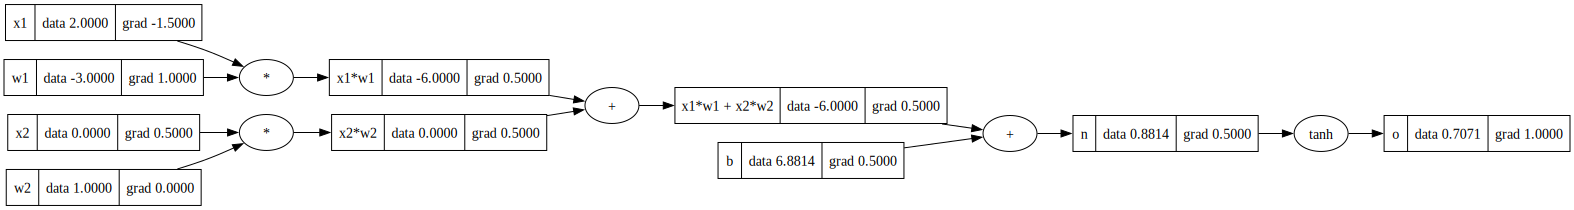

In [14]:
draw_dot(o)

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## Building micrograd using pytorch

In [ ]:
import torch 
import random


In [ ]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item()) 
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


In [49]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [50]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.899912403677696)

In [51]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target


In [52]:
ypred  = [n(x) for x in xs]
ypred

[Value(data=0.899912403677696),
 Value(data=-0.6756225031119805),
 Value(data=0.46605225920079746),
 Value(data=0.9140343866586659)]

In [53]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.2719376008098275)

In [54]:
loss.backward()

In [55]:
n.layers[0].neurons[0].w[0].grad

-0.4749478660703087

In [56]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 2.2719376008098275
1 0.2140868986651748
2 0.10482525561728712
3 0.07779409994246461
4 0.062303395695527355
5 0.05194169802058975
6 0.04446591111436772
7 0.03880794521456342
8 0.034376999091301645
9 0.03081530631523112
10 0.027892290659874273
11 0.025452280204007225
12 0.023386265708588455
13 0.0216156106252582
14 0.020082163373622813
15 0.018742003570882328
16 0.017561349203647825
17 0.016513799310776164
18 0.015578429415739439
19 0.014738446969558745


In [57]:
ypred

[Value(data=0.9430900230955953),
 Value(data=-0.9468729048676303),
 Value(data=-0.9316434292497281),
 Value(data=0.9367181503402588)]